# 0 Introduction
The following exercise is based on Tarn Duong, ["An Introduction to Kernel Density Estimation."](https://www.mvstat.net/tduong/research/seminars/seminar-2001-05/) Run the code in the next cell, which loads a sample of the log wingspans of aircraft built from 1956 to 1984 (original wingspans were in meters). Assume the data are sampled from a continuous distribution with a bimodal density, where the peaks in the density represent the modal log wingspans of small and large aircraft respectively.

In [3]:
import numpy as np
wings = np.array([2.05, 2.20, 2.35, 2.40, 2.45, 2.60, 2.65, 2.70, 3.35, 3.40, 3.60, 3.90])

# 1 Histograms
Histograms are dependent on bin width as well as bin boundaries. Varying either of these can cause features of the distribution from which a sample is drawn to appear or to become obscured. With the present dataset, we may gain or lose the appearance of bimodality.
    
- Plot a histogram of the data using bins of width 0.50, where the first bin is [1.00, 1.50).
- Plot a histogram of the data using bins of width 0.50, where the first bin is [1.25, 1.75).

(array([0., 2., 6., 0., 3., 1., 0., 0., 0., 0., 0.]),
 array([1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75, 6.25,
        6.75]),
 <BarContainer object of 11 artists>)

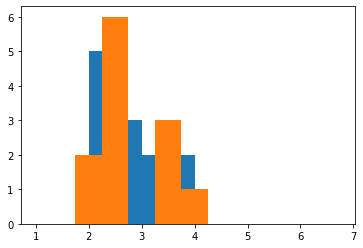

In [4]:
import matplotlib.pyplot as plt

def get_bin_size(edge):
    rList = []
    for i in range(len(wings)):
        rList.append(edge)
        edge += 0.5
    return rList
    
plt.hist(wings, bins=get_bin_size(1))
plt.hist(wings, bins=get_bin_size(1.25))

## Intepretation:

Sampling result may not be reflected accurately due to the choice of bin width and range. Ways to improve the accuracy:
- smaller bin width
- repeated trial of bin range
<br>

This prompts a need for finding better sampling method, which is KDE

# 2 Uniform Kernel Density Estimation
An advantage of kernel density estimation is that it does not depend on bin boundaries. It does however depend on bandwidth, which is an analogue of bin width.

- Manually implement a function that returns a uniform kernel density estimate given a vector of data and a bandwidth.
- Find a bandwidth that makes bimodality apparent and plot the results. State where the two modes appear to be.

0.12314814814814815

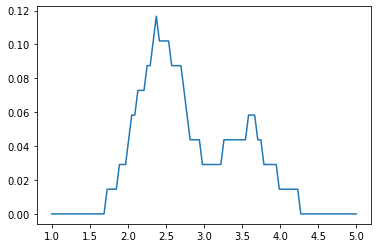

In [18]:
import scipy.stats as stat

# Concise lambda function implementing uniform kernel density estimation.
# This takes a sum of uniform PDF's that are scaled and centered according to the bandwidth and datapoints.

# The sum here is normalized by (1/(len(data)*bw)).
# Note that there are alternative, equivalent formulas.

# x: Points at which to evaluate the density estimate.
# data: Points on which to base the density estimate.

uniform_kde = lambda x, data, bandwidth: (1/len(data)*bandwidth) * sum([stat.uniform.pdf((x - data[i])/bandwidth, loc=-1, scale=2) \
                                            for i in range(len(data))])

# numpy.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None, axis=0)
x = np.linspace(1, 5, 100)
bandwidth=0.35
plt.plot(x, uniform_kde(x, wings, bandwidth))

# Check that the density estimate integrates to unity (~=1) using trapezoidal rule
np.trapz(uniform_kde(x, wings, bandwidth), x)  

# 3 Gaussian Kernel Density Estimation

This part repeats 2. but with Gaussian kernels. An advantage of Gaussian kernels over uniform kernels is that they result in a smoother estimated density curve.

- Manually implement a function that returns a Gaussian kernel density estimate given a vector of data and a bandwidth.
- Find a bandwidth that makes bimodality apparent and plot the results. State where the two modes appear to be.

[7.83119098e-108]


0.9999999912177029

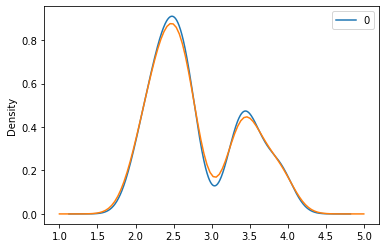

In [39]:
from scipy.stats import gaussian_kde

# 调包大法好
def kde_scipy(x, x_grid, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, **kwargs)
    return kde.evaluate(x_grid)

print(kde_scipy(wings, len(wings)))

# import matplotlib.pyplot as plt
# fig, ax = plt.subplots()
import pandas as pd
import numpy as np

df = pd.DataFrame(wings)
ax = df.plot.kde(bw_method=0.3)

# official solution:


# Gaussian kernel density estimation.
gkde = lambda x, data, bw: (1/(len(data)*bw)) * sum([stat.norm.pdf((x - data[i])/bw, loc=0, scale=1) \
                                for i in range(len(data))])

#2 Plot
x = np.linspace(1,5,100);
# Bandwidth.
bw = 0.2
plt.plot(x, gkde(x, wings, bw))
# Modes around 2.5 and 3.5.

# Check that the density estimate integrates to unity.
np.trapz(gkde(x, wings, bw), x)

# 4 Rejection Sampling
We will now attempt to sample from the Gaussian kernel density estimate. Read the first two pages of [this paper](https://academic.oup.com/biomet/article/89/4/745/242234) up to algorithm 2, empirical supremum rejection sampling. Implement a procedure that performs empirical supremum rejection sampling on the Gaussian kernel density estimate and plots a histogram of the resulting sample. Tune the parameters of the procedure to get the histogram to resemble the Gaussian kernel density estimate.

46
2.5476830814201294


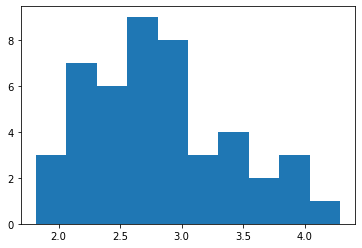

In [41]:
# no. of trials
n = 100

# n samples from a uniform[0, 1] distribution
# random_state: seed. None is default
u = stat.uniform.rvs(size=n, random_state=0)

# The candidate distribution is chosen to be a mixture of two Gaussians to resemble the target distribution.
# Means of 2.5 and 3.5 (as observed by graph above) are used to approximate the modes of the target distribution.
# Mixing probabilities of 2/3 and 1/3 are chosen to represent the relative sizes of the curves about the modes.
# With probability 2/3, draw from the first Gaussian, with probability 1/3 draw from the second.

# n samples from a candidate distribution.
# delta: Random variable representing whether draw is from first or second Gaussian.
delta = stat.bernoulli.rvs(2/3, size=n, random_state=0)
# x: the gaussian mixture random variable
x = delta*stat.norm.rvs(size=n, random_state=0, loc=2.5) + (1-delta)*stat.norm.rvs(size=n, random_state=0, loc=3.5)

# Initialize container for samples
samples = []
c = 1 + 1e-16

# sampling
for i in range(n):
    # candidate PDF
    cand = (2/3)*stat.norm.pdf(x[i], loc=2.5) + (1/3)*stat.norm.pdf(x[i], loc=3.5)
    # ratio 
    ratio = gkde(x[i], wings, bw) / cand
    # accept if a Uniform[0, 1] random variable is <= ratio / c
    if u[i] <= ratio / c:
        # append to list of samples
        samples.append(x[i])
    # from new estimation of supremum (上确界、最小上界)  
    c = max(c, ratio)

# plot histogram of samples
plt.hist(samples)
# no. of samples
print(len(samples))
# supremum estimate
print(c)

# Some features of the target distribution appear in the histogram.
# The procedure could be improved a better choice of candidate distribution.